In [3]:
import numpy as np
import tensorflow as tf
import t3f
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from gptt_embed.gpstruct import TTGPstruct
from gptt_embed import grid
from gptt_embed.covariance import SE_multidim
from gptt_embed.projectors import Identity
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [2]:
x_tr = np.load('data_struct/x_tr.npy')
x_te = np.load('data_struct/x_te.npy')
y_tr = np.load('data_struct/y_tr.npy')
y_te = np.load('data_struct/y_te.npy')

In [4]:
x_tr.shape

(100, 3, 4)

In [5]:
D = x_tr.shape[-1]

In [15]:
x_tr_flat = x_tr.reshape([-1, D])
x_te_flat = x_te.reshape([-1, D])

In [16]:
scaler = StandardScaler()
x_tr_flat = scaler.fit_transform(x_tr_flat)/3
x_te_flat = scaler.transform(x_te_flat)/3

In [17]:
x_tr = x_tr_flat.reshape(x_tr.shape)
x_te = x_te_flat.reshape(x_te.shape)

In [20]:
x_tr[x_tr > 1] = 1
x_tr[x_tr < -1] = -1
x_te[x_te > 1] = 1
x_te[x_te < -1] = -1

In [21]:
max_len = x_tr.shape[1]
n_labels = 4
n_seq = x_tr.shape[0]

## GP

In [23]:
num = 10
inputs = grid.InputsGrid(D, left=-1., right=1., npoints=num)
projector = Identity(D)
cov = SE_multidim(n_labels, .7, .3, .1, projector)

In [24]:
mu_ranks = 5
gp = TTGPstruct(cov, inputs, mu_ranks)

## Graph Creation

In [25]:
seq_lens = np.ones(shape=(n_seq,)) * max_len

In [27]:
x_tr = tf.constant(x_tr)
x_te = tf.constant(x_te)
y_tr = tf.constant(y_tr)
y_te = tf.constant(y_te)
seq_lens = tf.constant(seq_lens)

In [28]:
N = n_seq
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(1e-2, global_step, 
                                        50, 0.5, staircase=True)

In [29]:
elbo_op, train_op = gp.fit(x_tr, y_tr, seq_lens, N, lr, global_step)

_latent_vars_distribution/x_flat (?, 4) = sum_len x 4
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 4
cov_for_squared_dists/cov (4, 100, 3, 3) = [4, 100, 3, 3]
_Knns/K_nn (4, 100, 3, 3) = 4 x 100 x 3 x 3
_sample_f/f_un (4, 100, 3) = 4 100 3
_sample_f/f_bin (16,) = 16


## Learning

In [44]:
sess = tf.Session()
gp.initialize(sess)
sess.run(tf.global_variables_initializer())

In [45]:
maxiter = 300
elbo_vals = []
for i in range(maxiter):
    _, elbo = sess.run([train_op, elbo_op])
    print(elbo)
    elbo_vals.append(elbo)

420.723420493
448.224660951
431.967048546
442.6582077
434.296404547
428.186122397
429.049368787
427.878282855
425.220608041
424.338740643
426.32855159
426.073091727
422.591349755
423.39503181
422.533719096
423.238157012
422.316179116
422.407750305
422.897393201
422.994613476
419.573434591
419.717466463
419.879492643
418.665114104
420.123288307
418.128199689
418.658039207
417.380080114
418.419203431
416.365252401
418.178546761
417.462773584
415.75815047
416.859576269
415.397439543
417.280351282
417.035658505
415.925756503
417.4757311
415.656203383
416.537289109
416.173191688
416.042545846
415.026745222
416.796075783
415.630872763
416.420916856
415.074123603
417.015407515
415.924961833
416.02203468
416.367992151
415.468414956
414.635937245
416.934782397
416.536411042
418.020680162
416.626102035
417.117403169
414.826951929
416.559373197
415.653401109
415.141634536
415.495079011
415.686115883
416.318157532
415.767869785
415.629393061
416.398994774
415.155728459
415.574852082
414.44781189
4

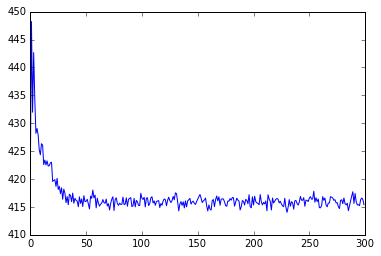

In [46]:
plt.plot(elbo_vals)

In [47]:
bin_mu = sess.run(gp.bin_mu)

In [48]:
for i in range(4):
    for j in range(4):
        print(i, j, bin_mu[i * 4 + j])

0 0 0.284346646432
0 1 0.48891260916
0 2 -0.441291968343
0 3 -0.465623057161
1 0 -0.487721928356
1 1 0.390642511319
1 2 0.47307786293
1 3 -0.52077310591
2 0 -0.441111372715
2 1 -0.486265298509
2 2 0.240500180407
2 3 0.243854299075
3 0 0.383966748784
3 1 -0.584314357754
3 2 -0.443184386154
3 3 0.364858928813


## Prediction

In [49]:
seq_lens_te = tf.constant(np.ones([x_te.shape[0]]) * max_len)

In [50]:
preds = gp.predict(x_te, seq_lens_te, sess)

_latent_vars_distribution/x_flat (?, 4) = sum_len x 4
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 4
cov_for_squared_dists/cov (4, 50, 3, 3) = [4, 50, 3, 3]
_Knns/K_nn (4, 50, 3, 3) = 4 x 50 x 3 x 3


In [51]:
np.sum(sess.run(y_te) == preds) / preds.size

0.99333333333333329

In [52]:
sess.close()